## Librerías

In [567]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import matplotlib.pyplot as plt
from googletrans import Translator
from deep_translator import GoogleTranslator
import time
import os 
import networkx as nx

## Funciones

In [ ]:
# Relative path
relative_path = os.getcwd()

# Buenas prácticas scrapping
headers = {
    'User-Agent': 'WikipediaEduBot/1.0 (User:natalia.gavalda; mailto:natalia.gavalda@goumh.umh.es)'
}

# Función para extraer subcategorías
def custom_extraccion_datos(url, idioma, html_div_name):    
    response = requests.get(url, headers=headers)
    exclusiones = ["Árbol de categorías", "Gráfico", "Tráfico", "Intersección", "Todas las páginas", "Página aleatoria", "Búsqueda interna", 
                   "Categories en arbre (gràfic)", "Categories en arbre", "gràfic", "Intersecció", "Totes les pàgines", "Pàgina a l'atzar", "Cerca interna"]
    nombre_array = []
    url_array = []

    # Extraemos dato si la página no da error
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        subcategorias = soup.select(f'div#mw-{html_div_name} a')
        
        for subcategoria in subcategorias:
            nombre = subcategoria.get_text()
            href = subcategoria.get('href')
            url = f'https://{idioma}.wikipedia.org' + href if href else None
            
            # Excluimos otras páginas y enlaces que no son artículos o catelgorias
            if nombre not in exclusiones and nombre != '':
                nombre_array.append(nombre)
                url_array.append(url)

    else:
        print(f'Error al acceder a la página. Código de estado: {response.status_code}')
    
    return nombre_array, url_array

# Función recursiva para extraer subcategorías y construir el árbol
def extraer_subcategorias_articulos(url, name, idioma, nivel=0):
    print(" " * nivel * 2 + f"Nivel {nivel} - Name: {name}")
    print(" " * nivel * 2 + f"Nivel {nivel} - URL: {url}")

    # Diccionario para almacenar los datos de la subcategoría actual
    json_file_sub_and_art = {
        "name": name,
        "url": url,
        "subcategories": [],
        "articulos": []
    }

    # Extraer subcategorías y artículos
    subcategories_name, subcategories_url = custom_extraccion_datos(url, html_div_name="subcategories", idioma=idioma)
    articulos_name, articulos_url = custom_extraccion_datos(url, html_div_name="pages", idioma=idioma)

    # Caso base: Si no hay subcategorías ni artículos, retornar el nodo actual
    if len(subcategories_url) == 0 and len(articulos_url) == 0:
        print(" " * nivel * 2 + "End Node")
        return json_file_sub_and_art

    # Procesar cada subcategoría recursivamente
    for i in range(len(subcategories_url)):
        sub_url = subcategories_url[i]
        sub_name = subcategories_name[i]
        # Añadir la subcategoría al árbol
        json_file_sub_and_art["subcategories"].append(extraer_subcategorias_articulos(sub_url, sub_name, idioma, nivel + 1))

    # Procesar cada artículo (sin recursividad)
    for i in range(len(articulos_url)):
        art_url = articulos_url[i]
        art_name = articulos_name[i]
        # Añadir el artículo al árbol como nodo final
        json_file_sub_and_art["articulos"].append({
            "name": art_name,
            "url": art_url
        })

    return json_file_sub_and_art

# Convertir un json a un dataframe
def json_to_dataframe(json_path):
    # Leer el archivo JSON
    with open(json_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    # Lista para almacenar los datos planos
    rows = []

    # Función recursiva para procesar las categorías y subcategorías
    def process_category(category, parent_name=None):
        category_name = category.get("name")
        category_url = category.get("url")

        # Procesar los artículos dentro de la categoría
        for article in category.get("articulos", []):
            rows.append({
                "category": category_name,
                "category_url": category_url,
                "article_name": article.get("name"),
                "article_url": article.get("url"),
                "parent_category": parent_name
            })

        # Procesar las subcategorías
        for subcategory in category.get("subcategories", []):
            process_category(subcategory, category_name)

    # Iniciar el procesamiento para cada categoría en el JSON
    for category in data:
        process_category(category)

    # Convertir la lista de datos en un DataFrame
    df = pd.DataFrame(rows)
    return df

# Extraer número de palabras de una lista de particulos
def extraer_num_palabras(lista_articulos):
    # Inicializar vacío el array donde guardamos las palabras por artículo
    total_palabras_articulo = []

    # Tipos de texto a encontrar en el HTML
    tipos_de_texto = ['p', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6']

    for i in range(len(lista_articulos)):
        # url
        url = lista_articulos[i]

        # Obtener el contenido de la página
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')

        # Extraer el texto del artículo (ignorando tablas y referencias)
        content = soup.find_all(tipos_de_texto)
        text = ' '.join([element.get_text() for element in content])

        # Contar el número de palabras
        word_count = len(text.split())

        # Guardar en un array
        total_palabras_articulo.append(word_count)
    
    return total_palabras_articulo
    

## Extraer la primera categoria y sus ariticulos

In [531]:
# Configuración
idioma='es'

if idioma=='es':
    # Configuración ES
    nombre_categoria_principal = "Baja Cerdaña"
    url_categoria_principal = 'https://es.wikipedia.org/wiki/Categor%C3%ADa:Municipios_de_la_Baja_Cerda%C3%B1a' 
    idioma = 'es'
elif idioma=='ca':
    # Configuración CAT
    nombre_categoria_principal = "Municipis de la Baixa Cerdanya"
    url_categoria_principal = 'https://ca.wikipedia.org/wiki/Categoria:Municipis_de_la_Baixa_Cerdanya' 
    idioma = 'ca'


# Subcategorias
subcategories_name_array, subcategories_url_array = custom_extraccion_datos(url_categoria_principal, html_div_name="subcategories", idioma=idioma)
print("Primeras subcategorias", subcategories_name_array)
print("Primeras URL subcategorias", subcategories_url_array)
print("Total de subcateogrias", len(subcategories_name_array))

# Páginas
pages_name_array, pages_url_array = custom_extraccion_datos(url_categoria_principal, html_div_name="pages", idioma=idioma)
print("Primeros artículos", pages_name_array)
print("Primeras URL artículos", pages_url_array)
print("Total de subcateogrias", len(pages_name_array))


Primeras subcategorias ['Bolvir', 'Das', 'Fontanáls de Cerdanya', 'Ger (Gerona)', 'Guils de Cerdaña', 'Isóbol', 'Lles', 'Llivia', 'Maranges', 'Montellá Martinet', 'Prulláns', 'Puigcerdá']
Primeras URL subcategorias ['https://es.wikipedia.org/wiki/Categor%C3%ADa:Bolvir', 'https://es.wikipedia.org/wiki/Categor%C3%ADa:Das', 'https://es.wikipedia.org/wiki/Categor%C3%ADa:Fontan%C3%A1ls_de_Cerdanya', 'https://es.wikipedia.org/wiki/Categor%C3%ADa:Ger_(Gerona)', 'https://es.wikipedia.org/wiki/Categor%C3%ADa:Guils_de_Cerda%C3%B1a', 'https://es.wikipedia.org/wiki/Categor%C3%ADa:Is%C3%B3bol', 'https://es.wikipedia.org/wiki/Categor%C3%ADa:Lles', 'https://es.wikipedia.org/wiki/Categor%C3%ADa:Llivia', 'https://es.wikipedia.org/wiki/Categor%C3%ADa:Maranges', 'https://es.wikipedia.org/wiki/Categor%C3%ADa:Montell%C3%A1_Martinet', 'https://es.wikipedia.org/wiki/Categor%C3%ADa:Prull%C3%A1ns', 'https://es.wikipedia.org/wiki/Categor%C3%ADa:Puigcerd%C3%A1']
Total de subcateogrias 12
Primeros artículos ['Alp

## Extracción de la jerarquia completo y guardado en formato json

In [532]:
# Lista para almacenar el árbol completo de todas las subcategorías
resultados = []
print(idioma)

# Iniciar la extracción para cada URL de la lista inicial
for i in range(0, len(subcategories_url_array)):
    url = subcategories_url_array[i]
    name = subcategories_name_array[i]
    resultados.append(extraer_subcategorias_articulos(url, name, idioma=idioma))

# Guardar el resultado en un archivo JSON
with open(f"subcategories_tree_{idioma}.json", "w", encoding="utf-8") as json_file:
    json.dump(resultados, json_file, ensure_ascii=False, indent=4)

print(f"Datos guardados en subcategories_tree_{idioma}.json")


es
Nivel 0 - Name: Bolvir
Nivel 0 - URL: https://es.wikipedia.org/wiki/Categor%C3%ADa:Bolvir
Nivel 0 - Name: Das
Nivel 0 - URL: https://es.wikipedia.org/wiki/Categor%C3%ADa:Das
Nivel 0 - Name: Fontanáls de Cerdanya
Nivel 0 - URL: https://es.wikipedia.org/wiki/Categor%C3%ADa:Fontan%C3%A1ls_de_Cerdanya
Nivel 0 - Name: Ger (Gerona)
Nivel 0 - URL: https://es.wikipedia.org/wiki/Categor%C3%ADa:Ger_(Gerona)
Nivel 0 - Name: Guils de Cerdaña
Nivel 0 - URL: https://es.wikipedia.org/wiki/Categor%C3%ADa:Guils_de_Cerda%C3%B1a
Nivel 0 - Name: Isóbol
Nivel 0 - URL: https://es.wikipedia.org/wiki/Categor%C3%ADa:Is%C3%B3bol
Nivel 0 - Name: Lles
Nivel 0 - URL: https://es.wikipedia.org/wiki/Categor%C3%ADa:Lles
Nivel 0 - Name: Llivia
Nivel 0 - URL: https://es.wikipedia.org/wiki/Categor%C3%ADa:Llivia
  Nivel 1 - Name: Arquitectura de Llivia
  Nivel 1 - URL: https://es.wikipedia.org/wiki/Categor%C3%ADa:Arquitectura_de_Llivia
  Nivel 1 - Name: Historia de Llivia
  Nivel 1 - URL: https://es.wikipedia.org/wiki/

## Visualizar jerarquia

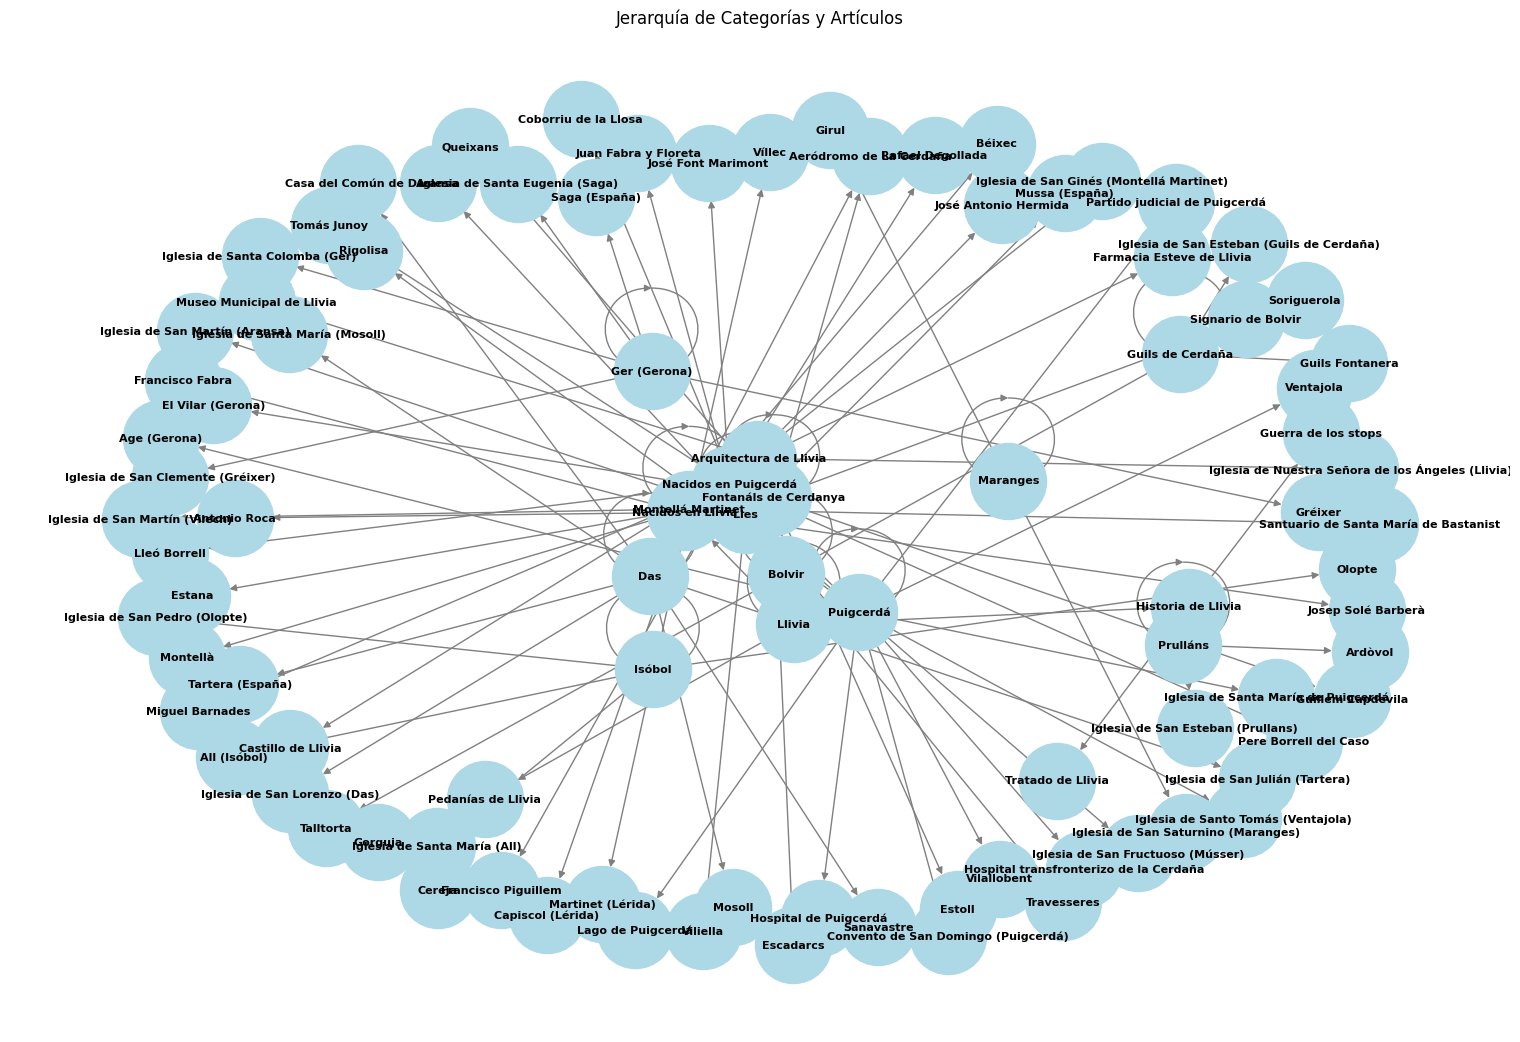

In [568]:
# Cargar el archivo JSON
file_path = relative_path + '/subcategories_tree_es.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Crear un grafo dirigido
G = nx.DiGraph()

# Función recursiva para agregar nodos y relaciones al grafo
def add_nodes_and_edges(category, parent=None):
    # Agregar nodo
    G.add_node(category['name'], url=category.get('url'))
    
    # Crear relación si hay un nodo padre
    if parent:
        G.add_edge(parent, category['name'])
    
    # Procesar subcategorías recursivamente
    for subcategory in category.get('subcategories', []):
        add_nodes_and_edges(subcategory, category['name'])
    
    # Procesar artículos como nodos sin subcategorías
    for article in category.get('articulos', []):
        G.add_node(article['name'], url=article.get('url'))
        G.add_edge(category['name'], article['name'])

# Procesar cada categoría principal
for category in data:
    add_nodes_and_edges(category)

# Dibujar el grafo
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=8, font_color="black", font_weight="bold", edge_color="gray", arrows=True)
plt.title("Jerarquía de Categorías y Artículos")
plt.show()

## Convertir json a dataframe

In [560]:
# Uso de la función
json_path = relative_path + '/subcategories_tree_es.json'
df_es = json_to_dataframe(json_path)
df_es['idioma'] = 'es'
print("Número de filas en español", len(df_es))

# Uso de la función
json_path = relative_path + '/subcategories_tree_ca.json'
df_ca = json_to_dataframe(json_path)
df_ca['idioma'] = 'ca'
print("Número de filas en catalan", len(df_ca))

# Unir ambos df
df = pd.concat([df_es, df_ca], ignore_index=True)

print(df.shape)
df.head()

Número de filas en español 91
Número de filas en catalan 1037
(1128, 6)


,category,category_url,article_name,article_url,parent_category,idioma
0,Bolvir,https://es.wikipedia.org/wiki/Categor%C3%ADa:B...,Bolvir,https://es.wikipedia.org/wiki/Bolvir,None,es
1,Bolvir,https://es.wikipedia.org/wiki/Categor%C3%ADa:B...,Signario de Bolvir,https://es.wikipedia.org/wiki/Signario_de_Bolvir,None,es
2,Bolvir,https://es.wikipedia.org/wiki/Categor%C3%ADa:B...,Talltorta,https://es.wikipedia.org/wiki/Talltorta,None,es
3,Das,https://es.wikipedia.org/wiki/Categor%C3%ADa:Das,Aeródromo de La Cerdaña,https://es.wikipedia.org/wiki/Aer%C3%B3dromo_d...,None,es
4,Das,https://es.wikipedia.org/wiki/Categor%C3%ADa:Das,Casa del Común de Das,https://es.wikipedia.org/wiki/Casa_del_Com%C3%...,None,es


# Analisis de datos

## Conteo de artículos en cada subcategoría
Contar los artículos de cada subcategoría y mostrar el resultado en un formato claro y ordenado, fácil de entender. Esta tarea ayudará a procesar y organizar datos obtenidos mediante scraping.

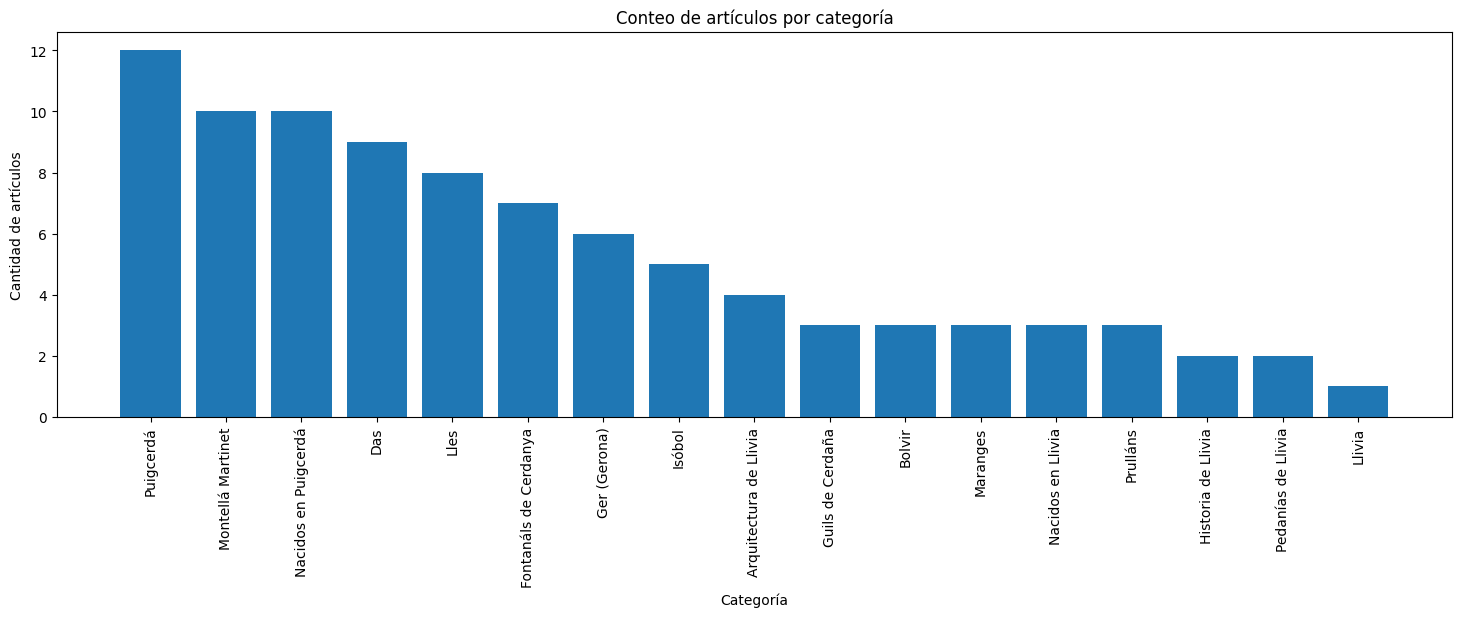

In [535]:
# Conteo de artículos por categoría ES
conteo_categorias = df_es.groupby('category')['article_name'].count().reset_index()
conteo_categorias.columns = ['category', 'count']
conteo_categorias = conteo_categorias.sort_values(by='count', ascending=False)

# Gráfico de barras
plt.figure(figsize=(18, 5))
plt.bar(conteo_categorias['category'], conteo_categorias['count'])
plt.title("Conteo de artículos por categoría")
plt.xlabel("Categoría")
plt.ylabel("Cantidad de artículos")
plt.xticks(rotation=90)
plt.show()

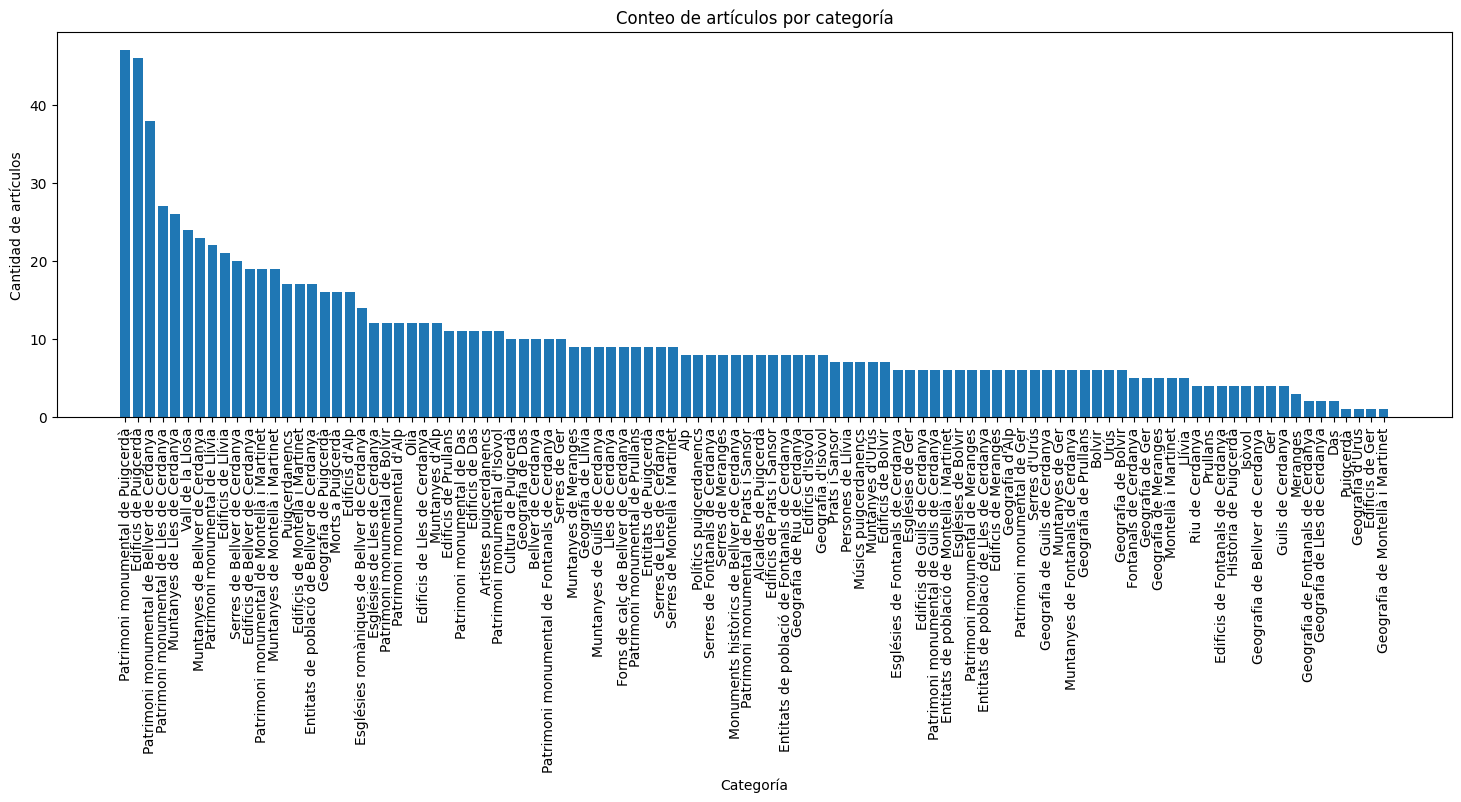

In [ ]:
# Conteo de artículos por categoría CA
conteo_categorias = df_ca.groupby('category')['article_name'].count().reset_index()
conteo_categorias.columns = ['category', 'count']
conteo_categorias = conteo_categorias.sort_values(by='count', ascending=False)

# Gráfico de barras
plt.figure(figsize=(18, 5))
plt.bar(conteo_categorias['category'], conteo_categorias['count'])
plt.title("Conteo de artículos por categoría")
plt.xlabel("Categoría")
plt.ylabel("Cantidad de artículos")
plt.xticks(rotation=90)
plt.show()

## Conteo de categorias y artículos únicos por idioma

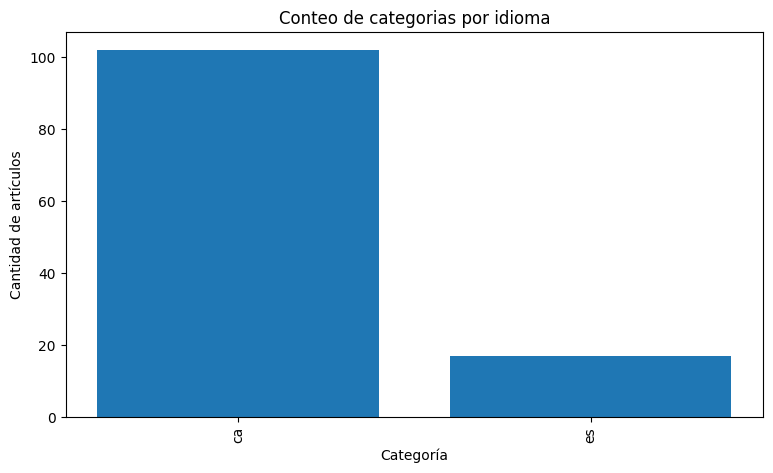

In [564]:
# Preparacion datos para hacer el gráfico
conteo_unico_categorias = df.groupby('idioma')['category'].nunique().reset_index()
conteo_unico_categorias.columns = ['idioma', 'unique_category_count']

# Gráfico de barras
plt.figure(figsize=(9, 5))
plt.bar(conteo_unico_categorias['idioma'], conteo_unico_categorias['unique_category_count'])
plt.title("Conteo de categorias por idioma")
plt.xlabel("Categoría")
plt.ylabel("Cantidad de artículos")
plt.xticks(rotation=90)
plt.show()

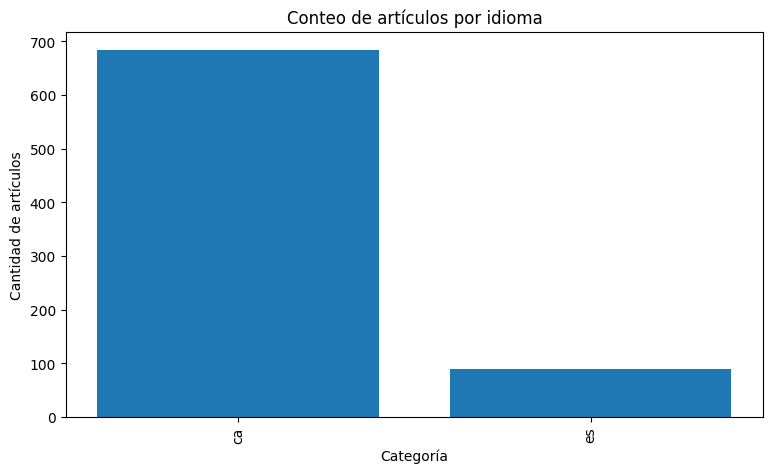

In [563]:
# Preparacion datos para hacer el gráfico
conteo_unico_articulos = df.groupby('idioma')['article_name'].nunique().reset_index()
conteo_unico_articulos.columns = ['idioma', 'unique_article_name_count']

# Gráfico de barras
plt.figure(figsize=(9, 5))
plt.bar(conteo_unico_articulos['idioma'], conteo_unico_articulos['unique_article_name_count'])
plt.title("Conteo de artículos por idioma")
plt.xlabel("Categoría")
plt.ylabel("Cantidad de artículos")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Lista para almacenar el árbol completo de todas las subcategorías
resultados = []
print(idioma)

# Iniciar la extracción para cada URL de la lista inicial
for i in range(0, len(subcategories_url_array)):
    url = subcategories_url_array[i]
    name = subcategories_name_array[i]
    resultados.append(extraer_subcategorias_articulos(url, name, idioma=idioma))

# Guardar el resultado en un archivo JSON
with open(f"subcategories_tree_{idioma}.json", "w", encoding="utf-8") as json_file:
    json.dump(resultados, json_file, ensure_ascii=False, indent=4)

print(f"Datos guardados en subcategories_tree_{idioma}.json")


es
Nivel 0 - Name: Bolvir
Nivel 0 - URL: https://es.wikipedia.org/wiki/Categor%C3%ADa:Bolvir
Nivel 0 - Name: Das
Nivel 0 - URL: https://es.wikipedia.org/wiki/Categor%C3%ADa:Das
Nivel 0 - Name: Fontanáls de Cerdanya
Nivel 0 - URL: https://es.wikipedia.org/wiki/Categor%C3%ADa:Fontan%C3%A1ls_de_Cerdanya
Nivel 0 - Name: Ger (Gerona)
Nivel 0 - URL: https://es.wikipedia.org/wiki/Categor%C3%ADa:Ger_(Gerona)
Nivel 0 - Name: Guils de Cerdaña
Nivel 0 - URL: https://es.wikipedia.org/wiki/Categor%C3%ADa:Guils_de_Cerda%C3%B1a
Nivel 0 - Name: Isóbol
Nivel 0 - URL: https://es.wikipedia.org/wiki/Categor%C3%ADa:Is%C3%B3bol
Nivel 0 - Name: Lles
Nivel 0 - URL: https://es.wikipedia.org/wiki/Categor%C3%ADa:Lles
Nivel 0 - Name: Llivia
Nivel 0 - URL: https://es.wikipedia.org/wiki/Categor%C3%ADa:Llivia
  Nivel 1 - Name: Arquitectura de Llivia
  Nivel 1 - URL: https://es.wikipedia.org/wiki/Categor%C3%ADa:Arquitectura_de_Llivia
  Nivel 1 - Name: Historia de Llivia
  Nivel 1 - URL: https://es.wikipedia.org/wiki/

## Análisis comparativo de artículos coincidentes

### Traducir los artículos

In [ ]:
# Definir el tamaño del lote
batch_size = 30  

# Lista para almacenar las traducciones
traducciones_completas = []

# Inicializar el traductor
traductor = GoogleTranslator(source='ca', target='es')

# Procesar el DataFrame en lotes para traducir articulos
for i in range(0, len(df), batch_size):
    batch_textos = df['article_name'][i:i + batch_size].tolist()
    try:
        traducciones = traductor.translate_batch(batch_textos)
        traducciones_completas.extend(traducciones)
    except Exception as e:
        print(f"Error al traducir el lote {i // batch_size + 1}: {e}")
        # En caso de error, agregar los textos originales sin traducir
        traducciones_completas.extend(batch_textos)
    time.sleep(1)  # Pausa para evitar sobrecargar la API

# Agregar las traducciones al DataFrame
df['article_name_es'] = traducciones_completas

# Guardar el DataFrame en un archivo CSV para que no volver a ejecutar
df.to_csv('datos_traducidos.csv', index=False, encoding='utf-8')

### Total de articulos coincidentes y únicos

In [565]:
# Lectura del fichero
path = relative_path + '/datos_traducidos.csv'
cols = ['category','category_url','article_name','article_url','parent_category','idioma','article_name_es']
df_traducciones = pd.read_csv(path, sep=',')

# Articulos en español y catalan
df_es = df_traducciones[ df_traducciones["idioma"]=='es' ]
df_ca = df_traducciones[ df_traducciones["idioma"]=='ca' ]
print("Número de articulos en catalán", 
      len(df_ca["article_name_es"].unique()))
print("Número de articulos en español", 
      len(df_es["article_name_es"].unique()))
print()

# Articulos coincidentes
df_coincidentes  = pd.merge(df_es, df_ca, on="article_name_es")
print("Número de articulos coincidentes en ambos idiomas", len(df_coincidentes["article_name_es"].unique()) )

# Articulos únicos en inglés y en catalán
print("Número de articulos únicos en español", 
      len(df_es["article_name_es"].unique()) - len(df_coincidentes["article_name_es"].unique()) )

print("Número de articulos únicos en catalán", 
      len(df_ca["article_name_es"].unique()) - len(df_coincidentes["article_name_es"].unique()) )

Número de articulos en catalán 683
Número de articulos en español 90

Número de articulos coincidentes en ambos idiomas 32
Número de articulos únicos en español 58
Número de articulos únicos en catalán 651


## Conteo de palabras de los artículos coincidentes

In [555]:
# Lista de artículos
articulos_coincidentes_es = df_coincidentes['article_url_x'].tolist()
articulos_coincidentes_ca = df_coincidentes['article_url_y'].tolist()

# Agregar el número de palabras 
df_coincidentes['num_palabras_x'] = extraer_num_palabras(articulos_coincidentes_es)
df_coincidentes['num_palabras_y'] = extraer_num_palabras(articulos_coincidentes_ca)

# Guardar el DataFrame en un archivo CSV para que no volver a ejecutar
df_coincidentes.to_csv('datos_articulos_coincidentes.csv', index=False, encoding='utf-8')

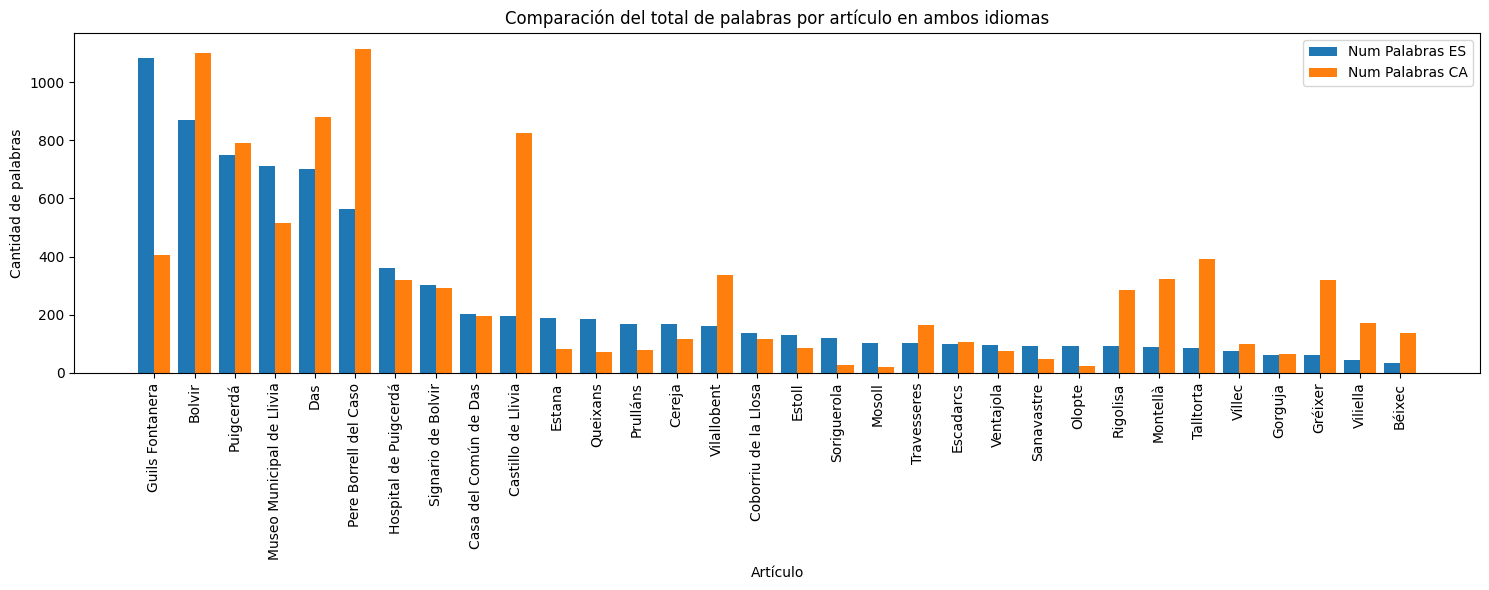

In [559]:
# Lectura del fichero
path = relative_path + '/datos_articulos_coincidentes.csv'
df_traducciones = pd.read_csv(path, sep=',')

# Preparación de los datos para el gráfico
articulos_palabras = df_traducciones.groupby('article_name_x')[['num_palabras_x', 'num_palabras_y']].mean().reset_index()
articulos_palabras.columns = ['article_name', 'num_palabras_es', 'num_palabras_ca']
articulos_palabras = articulos_palabras.sort_values(by='num_palabras_es', ascending=False)

# Gráfico de barras agrupadas
plt.figure(figsize=(15, 6))
bar_width = 0.4
x = range(len(articulos_palabras))

# Crear las barras
plt.bar(x, articulos_palabras['num_palabras_es'], width=bar_width, label='Num Palabras ES', align='center')
plt.bar([i + bar_width for i in x], articulos_palabras['num_palabras_ca'], width=bar_width, label='Num Palabras CA', align='center')

# Configuración del gráfico
plt.title("Comparación del total de palabras por artículo en ambos idiomas")
plt.xlabel("Artículo")
plt.ylabel("Cantidad de palabras")
plt.xticks([i + bar_width / 2 for i in x], articulos_palabras['article_name'], rotation=90)
plt.legend()
plt.tight_layout()